In [8]:
import pathlib
import tensorflow as tf


dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"

# after this code runs, data_dir will contain the path to the extracted directory,
# and you can use it to load and process the dataset.
# "untar" automatically extracts the contents of a tar file after downloading it.
data_dir = pathlib.Path(tf.keras.utils.get_file('flower_photos', origin = dataset_url, untar = True))

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


In [9]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


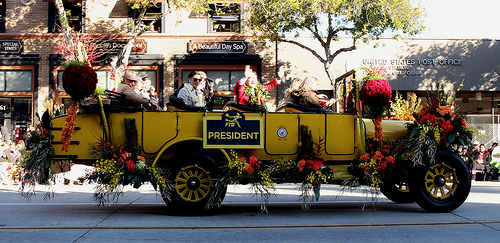

In [10]:
import PIL
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

In [13]:
# load dataset using keras

batch_size = 32
img_height = 180
img_width = 180

# subset: Indicates which subset of the data to return. It can be either "training" or "validation".
# This helps in generating datasets for training and validation from the same directory.
train_dataset = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split = 0.2, subset = "training", seed = 123, image_size = (img_height, img_width), batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [15]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(data_dir, validation_split = 0.2, subset = "validation", seed = 123, image_size = (img_height, img_width), batch_size = batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [17]:
class_names = train_dataset.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


-----


2024-07-13 15:52:23.139576: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


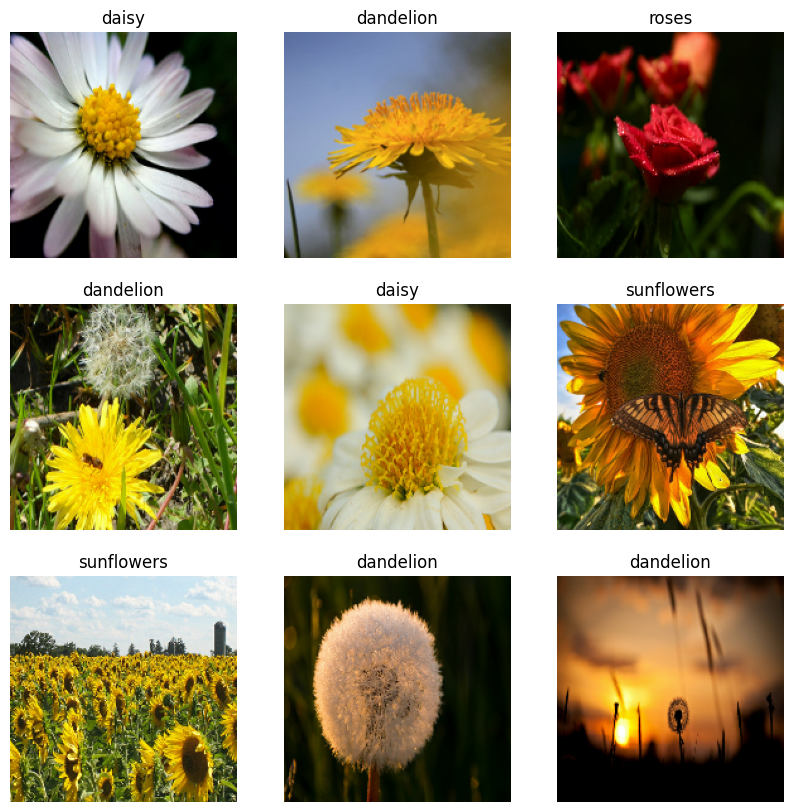

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# what does take method return?
# train_dataset.take(1) returns a dataset containing just the first "batch" from train_dataset.
for sample_images, sample_labels in train_dataset.take(1):
  print("-----")
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)

    # why do we need to use numpy and uint8?
    # sample_images[i].numpy(): In TensorFlow, sample_images is a tensor. The .numpy() method converts
    # the tensor to a NumPy array. This is necessary because Matplotlib's imshow function expects a
    # NumPy array rather than a TensorFlow tensor.

    # .astype("uint8"): The astype("uint8") method converts the data type of the NumPy array to unsigned
    # 8-bit integers (uint8). This is necessary because image data is typically represented as 8-bit
    # integers (values ranging from 0 to 255) when displaying images. Without this conversion, the
    # data might be in a different format (e.g., float32), which could cause issues or unexpected
    # behavior when displaying the image.
    plt.imshow(sample_images[i].numpy().astype("uint8"))
    plt.title(class_names[sample_labels[i]])
    plt.axis("off")

In [23]:
# configure the dataset for performance 為了能跑快一點
AUTOTUNE = tf.data.AUTOTUNE

# train_dataset.cache(): This method caches the dataset in memory. This means that the data will be
# loaded only once from disk and then kept in memory for faster access in subsequent epochs. This can
# significantly speed up the training process, especially if the dataset fits into memory.

# train_dataset.shuffle(1000): This method shuffles the dataset to ensure that the data is randomly
# mixed, which helps in reducing the variance and ensuring that the model generalizes well. The
# number 1000 specifies the buffer size for shuffling. TensorFlow will maintain a buffer of 1000
# elements and randomly sample elements from this buffer.

# train_dataset.prefetch(buffer_size=AUTOTUNE): This method allows the data to be pre-fetched, i.e.,
# it prepares the next batch of data while the current batch is being processed by the model. Using
# AUTOTUNE lets TensorFlow automatically determine the optimal buffer size for prefetching, which
# can improve the input pipeline performance.
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size = AUTOTUNE)

In [26]:
import tensorflow.keras.layers as layers
import numpy as np

normalization_layer = layers.Rescaling(1./255)

# iter(normalized_dataset): Converts the normalized_dataset into an iterator.
# next(...): Retrieves the next item from the iterator, which in this case is a
# batch of images and their corresponding labels.
normalized_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
images_batch, labels_batch = next(iter(normalized_dataset))
first_image = images_batch[0]
print(np.min(first_image), np.max(first_image))

0.0 1.0
